In [1]:
## sostituire questa cartella con folder locale. la cartella può essere scaricata da qui:
# https://github.com/gabrielepinto/dati_simulatore_elettorale/dati_app
folder_head="D:\\database_vari_miei\\simulatore\\dati_app\\"

# importa moduli necessari
# N.B. controllare che il file funzionisimulatore.py si trovi nella cartella. il modulo può essere scaricato da qui:
# https://github.com/gabrielepinto/dati_simulatore_elettorale/
#from funzionisimulatore import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def aumento_voti_territorio(data,increase=0.35,
                            partito="LEGA",
                            unit_name="COLLEGIOUNINOMINALE",
                            unit='Piemonte 1 - U01'):
    '''
    data= sono i dati elettorali
    increase = la percentuale a cui si vuole portare quel partito
    partito = nome partito
    unit_name = a quale livello vuoi cambiare percentuale
    unit = nome del colleggio o area
    '''
    ## calcolo percentuale
    perc_attuale=data.loc[(data["LISTA"]==partito)&(data[unit_name]==unit),"VOTI_LISTA"].sum()/data.loc[(data[unit_name]==unit),"VOTANTI"].unique()[0]
    ### individua l'/le unità da modificare
    unit_to_edit=data.loc[(data["LISTA"]==partito)&(data[unit_name]==unit),"VOTI_LISTA"].copy()
    data.loc[unit_to_edit.index,"VOTI_LISTA"]=unit_to_edit*(increase/perc_attuale)
    nuovo_valore=data.loc[unit_to_edit.index,"VOTI_LISTA"]
    diff_da_riallocare=nuovo_valore-unit_to_edit
    # ### individua quelle da aggiustare
    units_to_adjust=data.loc[(~data.index.isin(unit_to_edit.index))&(data["LISTA"]==partito)].index
    pesi=data.loc[units_to_adjust,"VOTANTI"]/data.loc[units_to_adjust,"VOTANTI"].sum()
    data.loc[units_to_adjust,"VOTI_LISTA"]=data.loc[units_to_adjust,"VOTI_LISTA"]-pesi*diff_da_riallocare.values[0]

    return data


def aumento_voti_partito(data,increase=0.25,
                            partito="FORZA ITALIA"):
    '''
    data= sono i dati elettorali
    increase = la percentuale a cui si vuole portare quel partito
    partito = nome partito
    '''
    ## percentuale attuale
    perc_attuale=data.loc[(data["LISTA"]==partito),"VOTI_LISTA"].sum()/data["VOTI_LISTA"].sum()
    ### individua l'/le unità da modificare
    unit_to_edit=data.loc[(data["LISTA"]==partito),"VOTI_LISTA"]
    nuovo_valore=data.loc[unit_to_edit.index,"VOTI_LISTA"]=unit_to_edit*(increase/perc_attuale)
    diff_da_riallocare=(nuovo_valore-unit_to_edit).sum()
    ### individua quelle da aggiustare
    units_to_adjust=data.loc[data["LISTA"]!=partito].index
    pesi=data.loc[units_to_adjust,"VOTI_LISTA"]/data.loc[units_to_adjust,"VOTI_LISTA"].sum()
    data.loc[units_to_adjust,"VOTI_LISTA"]=data.loc[units_to_adjust,"VOTI_LISTA"]-pesi*diff_da_riallocare
    
    return data





def sporziona_hare(vot,seat):
    quota=vot.sum()/seat
    apportion=vot/quota
    apportion=apportion.astype("int")
    ### partiti ai quali aggiungere dei voti
    seggi_rimanenti=seat-sum(apportion) 
    resti=(vot/quota)-(vot/quota).apply(lambda x:int(x)).values
    index_to_add=resti.sort_values(ascending=False).iloc[:seggi_rimanenti].index
    apportion[index_to_add]+=1
    return apportion


def compute_uninom(camera,diz):
    '''
    camera sono i dati della camera in formato long
    '''
    uninom=camera.groupby(["COLLEGIOUNINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum()
    ## aggiungi coalizione
    uninom["COALIZIONE"]=uninom["LISTA"].replace(diz)
    ## raggruppa e calcola risultato per coalizione
    uninom=uninom.groupby(["COLLEGIOUNINOMINALE","COALIZIONE"],as_index=False)["VOTI_LISTA"].sum().pivot(index="COLLEGIOUNINOMINALE",columns="COALIZIONE",values="VOTI_LISTA").fillna(0)



    partiti=uninom.columns
    seggi=uninom[partiti].apply(lambda x:(-x).argsort()[0],axis=1).value_counts()
    uninom_camera=pd.DataFrame({"partiti":pd.Series(partiti).loc[seggi.index],"seggi":seggi.values})

    ### questo è per visualizzare breakdown da partito mentre uninom_camera è quello che li visualizza per coalizione
    uninom_camera_per_partito=pd.DataFrame()
    for i,row in uninom_camera.iterrows():
        percentuali_within_list=camera.loc[camera["LISTA"].isin(row.partiti.split("*"))].groupby("LISTA",as_index=False)["VOTI_LISTA"].sum()
        ##
        perc_partiti=pd.merge(pd.DataFrame({"LISTA":row.partiti.split("*")}),percentuali_within_list).set_index("LISTA").transpose()
        seggi=sporziona_hare(perc_partiti.iloc[0],row.seggi)


        uninom_camera_per_partito=uninom_camera_per_partito.append(pd.DataFrame({"partiti":perc_partiti.columns,"seggi":seggi}))
    uninom_camera_per_partito=uninom_camera_per_partito.sort_values("seggi",ascending=False).reset_index(drop=True)
    uninom_camera_per_partito=uninom_camera_per_partito.loc[uninom_camera_per_partito["seggi"]!=0,:].reset_index(drop=True)
    return(uninom_camera_per_partito.sort_values("seggi",ascending=False).reset_index(drop=True))
    


def compute_plurinom_camera(camera,diz,seggi_plurinominale=245):
    ### soglia 3%
    perc_partiti=camera.groupby("LISTA")["VOTI_LISTA"].sum()/camera["VOTI_LISTA"].sum()
    p1=list(perc_partiti.loc[perc_partiti>=0.03].index)

    ### soglia 1% partiti in coalizione
    coalizioni=[x for x in np.unique(list(diz.values())) if "*" in x]
    partito_in_coalizioni=[partito for partito in camera.LISTA.unique() if any(partito in coalizione for coalizione in coalizioni)]
    p2=list(perc_partiti.loc[perc_partiti.index.isin(partito_in_coalizioni)&(perc_partiti>=0.01),].index)

    ### soglia 20 % circoscrizione per SVP

    circoscrizione=camera.loc[camera["LISTA"]=="SVP"].groupby(["LISTA","CIRCOSCRIZIONE"],as_index=False)["VOTI_LISTA"].sum()

    circoscrizione=pd.merge(circoscrizione,
            camera.groupby("CIRCOSCRIZIONE",as_index=False)["VOTI_LISTA"].sum().rename({"VOTI_LISTA":"VOTI_TOTALE"},axis=1),on="CIRCOSCRIZIONE",how="left")
    p3=list(circoscrizione.loc[(circoscrizione["VOTI_LISTA"]/circoscrizione["VOTI_TOTALE"])>0.2,"LISTA"].unique())

    ### seleziona partiti ammessi
    partiti_ammessi=list(set(p1).union(set(p2)).union(set(p3)))
    cam=camera.loc[camera.LISTA.isin(partiti_ammessi)].copy()


    ## ripartizione coalizioni
    seggi_coalizione=sporziona_hare(cam.replace(diz).groupby("LISTA")["VOTI_LISTA"].sum(),
                  seggi_plurinominale)
    seggi_coalizione=pd.DataFrame({"seggi":seggi_coalizione.values,"partiti":seggi_coalizione.index})

    plurinom_camera=pd.DataFrame()
    ### ripartizione liste
    for i,row in seggi_coalizione.iterrows():
        # lista partiti nella coalizione
        parties_coalizione=row.partiti.split("*")
        # rialloca all'interno della coalizione
        seggi_una_coalizione=sporziona_hare(camera.groupby("LISTA")["VOTI_LISTA"].sum().loc[parties_coalizione],
                      row.seggi)

        plurinom_camera=plurinom_camera.append(pd.DataFrame({"seggi":seggi_una_coalizione.values,"partiti":seggi_una_coalizione.index}))

    plurinom_camera=plurinom_camera.groupby("partiti",as_index=False)["seggi"].sum()

    return plurinom_camera.sort_values("seggi",ascending=False).reset_index(drop=True)


def compute_plurinom_senato(camera,diz,by_region=0):
    
    ### soglia 3%
    perc_partiti=camera.groupby("LISTA")["VOTI_LISTA"].sum()/camera["VOTI_LISTA"].sum()
    p1=list(perc_partiti.loc[perc_partiti>=0.03].index)

    ### soglia 1% partiti in coalizione
    coalizioni=[x for x in np.unique(list(diz.values())) if "*" in x]
    partito_in_coalizioni=[partito for partito in camera.LISTA.unique() if any(partito in coalizione for coalizione in coalizioni)]
    p2=list(perc_partiti.loc[perc_partiti.index.isin(partito_in_coalizioni)&(perc_partiti>=0.01),].index)

    ### soglia 20 % regione

    circoscrizione=camera.groupby(["LISTA","CODICE_REGIONE"],as_index=False)["VOTI_LISTA"].sum()

    circoscrizione=pd.merge(circoscrizione,
            camera.groupby("CODICE_REGIONE",as_index=False)["VOTI_LISTA"].sum().rename({"VOTI_LISTA":"VOTI_TOTALE"},axis=1),on="CODICE_REGIONE",how="left")
    p3=list(circoscrizione.loc[(circoscrizione["VOTI_LISTA"]/circoscrizione["VOTI_TOTALE"])>0.2,"LISTA"].unique())

    ### seleziona partiti ammessi
    partiti_ammessi=list(set(p1).union(set(p2)).union(set(p3)))
    cam=camera.loc[camera.LISTA.isin(partiti_ammessi)].copy()


    ## per ogni regione
    plurinom_camera=pd.DataFrame()
    for i,region in seggi_senato.iterrows():

        ## ripartizione coalizioni
        cam_regione=cam.loc[cam["CODICE_REGIONE"]==region.CODICE_REGIONE]

        seggi_coalizione=sporziona_hare(cam_regione.replace(diz).groupby("LISTA")["VOTI_LISTA"].sum(),
                      region.seggi)
        seggi_coalizione=pd.DataFrame({"seggi":seggi_coalizione.values,"partiti":seggi_coalizione.index,"CODICE_REGIONE":region.CODICE_REGIONE})


        ### ripartizione liste
        for i,row in seggi_coalizione.iterrows():
            # lista partiti nella coalizione as esclusione di quelli non ammessi
            parties_coalizione=[x for x in row.partiti.split("*") if x in partiti_ammessi]
            # rialloca all'interno della coalizione
            if row.seggi!=0:            
                seggi_una_coalizione=sporziona_hare(cam_regione.groupby("LISTA")["VOTI_LISTA"].sum().loc[parties_coalizione],
                              row.seggi)
                plurinom_camera=plurinom_camera.append(pd.DataFrame({"seggi":seggi_una_coalizione.values,"partiti":seggi_una_coalizione.index,"COD_REGIONE":row.CODICE_REGIONE}))

    if by_region!=0:
        plurinom_camera=plurinom_camera.groupby(["partiti","COD_REGIONE"],as_index=False)["seggi"].sum()
    else:
        plurinom_camera=plurinom_camera.groupby(["partiti"],as_index=False)["seggi"].sum()
    plurinom_camera=plurinom_camera.sort_values("seggi",ascending=False).reset_index(drop=True)
    
    return plurinom_camera
    

def cp(partito,mean=1):
    perc_attuale=camera.loc[camera["LISTA"]==partito,"VOTI_LISTA"].sum()/camera["VOTI_LISTA"].sum()
    return np.round(perc_attuale*mean,4)

def compute_gauge_data(result,diz):
    gauge_data=pd.DataFrame(result.groupby("partiti")["seggi"].sum()).reset_index(drop=False)
    gauge_data["color"]=gauge_data.partiti.apply(lambda x:diz_colori[x])
    gauge_data["order"]=gauge_data.partiti.apply(lambda x:diz_order[x])
    gauge_data["coalizione"]=gauge_data["partiti"].replace(diz)

    list_gauge=[]
    z=0
    for i,row in gauge_data.sort_values("order",ascending=True).iterrows():
        list_gauge.append({"range":[z,z+row.seggi],"color":row.color})
        z+=row.seggi
    return gauge_data,list_gauge

def create_fig_gauge(maggioranza,lista_gauge,maggioranza_richiesta=201,totale_posti=400,nome_graf="Camera"):
    fig_gauge = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = maggioranza,
    mode = "gauge+number+delta",
    title = {'text': nome_graf},
    delta = {'reference': +totale_posti/2 },
    gauge = {'bar': {'color': "lightgrey","thickness":0.2},
        'axis': {'range': [None, totale_posti]},
            'steps' : lista_gauge,
            ### questo + il valore della barragrigia
            'threshold' : {'line': {'color': "red", 'width': 3}, 'thickness': 0.3, 'value': maggioranza_richiesta}}))
    return fig_gauge



def tabella_uninom(camera,diz):
    uninom=camera.groupby(["COLLEGIOUNINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum()
    ## aggiungi coalizione
    uninom["COALIZIONE"]=uninom["LISTA"].replace(diz)
    ## raggruppa e calcola risultato per coalizione
    uninom=uninom.groupby(["COLLEGIOUNINOMINALE","COALIZIONE"],as_index=False)["VOTI_LISTA"].sum().pivot(index="COLLEGIOUNINOMINALE",columns="COALIZIONE",values="VOTI_LISTA").fillna(0)
    partiti=uninom.columns
    uninom=(uninom.div(uninom.sum(axis=1), axis=0)*100).round(1)
    uninom["MARGINE"]=uninom.apply(lambda x:np.round(x.sort_values()[-1]-x.sort_values()[-2],2),axis=1)
    uninom["VINCITORE"]=uninom[partiti].apply(lambda x:(-x).argsort()[0],axis=1).replace(dict(zip([x for x in range(0,uninom.columns.shape[0])],uninom.columns)))
    return uninom


def scenario_base(camera):
    return pd.DataFrame({"percentuali":[cp(party,1) for party in camera["LISTA"].unique()],"partito":camera["LISTA"].unique()}).sort_values("percentuali",ascending=False).reset_index(drop=True)

def allocazione_plurinom_camera(camera,diz,seggi_camera):
    big_df=pd.DataFrame()
    ### filtra per circoscrizioni che hanno collegi plurinominali
    circoscrizioni=seggi_camera.CIRCOSCRIZIONE.unique()
    for circoscrizione in circoscrizioni:
        big_df=big_df.append(allocazione_plurinominali_camera_liste(camera,diz=diz_coalizione,circoscrizione_scelta=circoscrizione))
    return big_df.reset_index(drop=True).pivot_table(index="COLLEGIOPLURINOMINALE",columns="LISTA",values="seggi_finali").fillna(0)


def allocazione_plurinom_senato(camera,diz,seggi_senato):
    big_df=pd.DataFrame()
    ### filtra per circoscrizioni che hanno collegi plurinominali
    regioni=seggi_senato.CODICE_REGIONE.unique()
    for region in regioni:
        big_df=big_df.append(allocazione_plurinominali_senato_liste(camera=camera,diz=diz,codice_regione=region))
    return big_df.reset_index(drop=True).pivot_table(index="COLLEGIOPLURINOMINALE",columns="LISTA",values="seggi_finali").fillna(0)


def allocazione_plurinominali_senato_liste(camera,diz,codice_regione=1):
    ### DECRETO LEGISLATIVO 20 dicembre 1993, n. 533 , art 17, comma C

    ## seggi spettanti a livello  di COD_REGIONE
    allocazioni_circoscrizioni=compute_plurinom_senato(camera,diz=diz,by_region=1)
    allocazioni_circoscrizioni.rename({"partiti":"LISTA"},axis=1,inplace=True)
    allocazioni_circoscrizioni=allocazioni_circoscrizioni.loc[allocazioni_circoscrizioni["COD_REGIONE"]==codice_regione,:]
    ##  calcola cifra elettorale coalizioni
    all_results_camera=pd.merge(camera,senato_match[["COLLEGIOUNINOMINALE","COLLEGIOPLURINOMINALE"]],on="COLLEGIOUNINOMINALE")
    cifre_collegi_liste=all_results_camera.groupby(["COLLEGIOPLURINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum()
    ## filtra ammessi al voto
    cifre_collegi_liste=cifre_collegi_liste.loc[cifre_collegi_liste["LISTA"].isin(allocazioni_circoscrizioni.LISTA.unique())]


    '''
     nelle regioni ripartite in piu' collegi plurinominali, procede
    quindi alla distribuzione nei singoli collegi plurinominali dei seggi
    assegnati alle liste. A tale fine, per ciascun collegio plurinominale
    divide la somma delle cifre elettorali di collegio delle  liste  alle
    quali devono essere assegnati  seggi  per  il  numero  dei  seggi  da
    attribuire nel collegio plurinominale, ottenendo cosi'  il  quoziente
    elettorale di collegio.  Nell'effettuare  tale  divisione  non  tiene
    conto dell'eventuale parte frazionaria del quoziente cosi'  ottenuto.
    Divide poi la cifra elettorale di collegio di ciascuna lista  per  il
    quoziente elettorale di collegio, ottenendo  cosi'  il  quoziente  di
    attribuzione.  La  parte  intera  del   quoziente   di   attribuzione
    rappresenta il numero dei seggi da  assegnare  a  ciascuna  lista.  I
    seggi  che  rimangono  ancora  da  attribuire  sono   rispettivamente
    assegnati alle liste per le quali queste ultime divisioni hanno  dato
    le maggiori parti decimali e, in caso  di  parita',  alle  liste  che
    hanno conseguito la maggiore cifra elettorale di collegio; a  parita'
    di quest'ultima si procede a sorteggio.
    '''
    cifre_collegi_liste=pd.merge(cifre_collegi_liste,senato_match[["COLLEGIOPLURINOMINALE","COD_REGIONE"]].drop_duplicates(),how="left",on="COLLEGIOPLURINOMINALE")
    cam_cifre=pd.merge(cifre_collegi_liste,seggi_senato_plurinominale,on=["COLLEGIOPLURINOMINALE","COD_REGIONE"],how="left")
    cam_cifre=cam_cifre.loc[cam_cifre["COD_REGIONE"]==codice_regione]
    cam_cifre["QUOZIENTE"]=cam_cifre.groupby("COLLEGIOPLURINOMINALE")["VOTI_LISTA"].transform("sum")/cam_cifre["seggi"]



    cam_cifre["QUOZIENTE_ATTRIBUZIONE"]=cam_cifre["VOTI_LISTA"]/cam_cifre["QUOZIENTE"]
    cam_cifre["SEGGI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"].apply(lambda x:int(x))
    cam_cifre["RESTI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_1"]
    cam_cifre["ORDINE_RESTI_1"]=cam_cifre.groupby("COLLEGIOPLURINOMINALE")["RESTI_1"].transform("rank",ascending=False)
    cam_cifre["SEGGI_DA_ASSEGNARE_2"]=cam_cifre["seggi"]-cam_cifre.groupby("COLLEGIOPLURINOMINALE")["SEGGI_1"].transform("sum")
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]<=cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=1
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]>cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=0
    cam_cifre["SEGGI_ASSEGNATI"]=cam_cifre["SEGGI_1"]+cam_cifre["SEGGI_2"]
    cam_cifre["RESTI_2"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_ASSEGNATI"]
    '''
    Successivamente  l'ufficio  accerta  se  il
    numero dei seggi assegnati  in  tutti  i  collegi  a  ciascuna  lista
    corrisponda  al  numero   di   seggi   ad   essa   attribuito   nella
    circoscrizione (COD_REGIONE) dall'Ufficio elettorale centrale  nazionale.
    '''

    cam_cifre=pd.merge((allocazioni_circoscrizioni.groupby("LISTA",as_index=False)["seggi"].sum()).rename({"seggi":"SEGGI_NAZIONALI"},axis=1),cam_cifre,on="LISTA")
    cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]=cam_cifre.groupby("LISTA")["SEGGI_ASSEGNATI"].transform("sum")
    ci_sono_modifiche_da_fare=((cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]==cam_cifre["SEGGI_NAZIONALI"])==False).any()

    if ci_sono_modifiche_da_fare:
        #### if
        ''' 
    In  caso negativo, determina la lista  che  ha  il  maggior  numero  di  seggi
    eccedentari (ECCEDENZA) e, a parita' di essi, la lista che tra queste ha ottenuto
    il seggio eccedentario con la minore parte  decimale  del  quoziente (RESTI_1);
    sottrae quindi il seggio a tale lista nel collegio in  cui  e'  stato
    ottenuto con la minore parte decimale dei quozienti di attribuzione e
    lo assegna alla lista deficitaria che ha il maggior numero  di  seggi
    deficitari e, a parita' di essi, alla lista  che  tra  queste  ha  la
    maggiore  parte  decimale  del  quoziente (RESTI_1)  che  non  ha  dato   luogo
    all'assegnazione  di  seggio;  il  seggio  e'  assegnato  alla  lista
    deficitaria nel collegio plurinominale in cui  essa  ha  la  maggiore
    parte decimale del quoziente di attribuzione non  utilizzata;  ripete
    quindi, in successione,  tali  operazioni  sino  all'assegnazione  di
    tutti i seggi eccedentari alle liste deficitarie)). 
        '''
        cam_cifre["ECCEDENZA"]=cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]-cam_cifre["SEGGI_NAZIONALI"]
        ordine=cam_cifre.groupby(["ECCEDENZA","LISTA","COLLEGIOPLURINOMINALE"],as_index=False)["RESTI_1"].min().sort_values(["ECCEDENZA","RESTI_1"],ascending=False).copy()

        ### eccedentarie
        eccedentarie=ordine.loc[ordine["ECCEDENZA"]>0]
        eccedentarie=eccedentarie.groupby(["LISTA","COLLEGIOPLURINOMINALE","ECCEDENZA"],as_index=False)["RESTI_1"].min().sort_values("RESTI_1")
        da_levare=pd.DataFrame()
        for lista in eccedentarie["LISTA"].unique():
            da_togliere=int(eccedentarie.loc[eccedentarie["LISTA"]==lista,"ECCEDENZA"].iloc[0])
            da_levare=da_levare.append(eccedentarie.loc[eccedentarie["LISTA"]==lista,:].iloc[0:da_togliere])

        ### deficitarie
        ### eccedentarie
        deficitarie=ordine.loc[ordine["ECCEDENZA"]<0]
        deficitarie=deficitarie.groupby(["LISTA","COLLEGIOPLURINOMINALE","ECCEDENZA"],as_index=False)["RESTI_1"].min().sort_values("RESTI_1",ascending=False)
        da_aggiungere=pd.DataFrame()
        for lista in deficitarie["LISTA"].unique():
            da_aumentare=abs(int(deficitarie.loc[deficitarie["LISTA"]==lista,"ECCEDENZA"].iloc[0]))
            da_aggiungere=da_aggiungere.append(deficitarie.loc[deficitarie["LISTA"]==lista,:].iloc[0:da_aumentare])

        ### correzioni
        cam_cifre["CORREZIONE"]=0
        for i,row in da_aggiungere.iterrows():
            cam_cifre.loc[(cam_cifre["LISTA"]==row.LISTA)&(cam_cifre["COLLEGIOPLURINOMINALE"]==row.COLLEGIOPLURINOMINALE),"CORREZIONE"]+=1
        for i,row in da_levare.iterrows():
            cam_cifre.loc[(cam_cifre["LISTA"]==row.LISTA)&(cam_cifre["COLLEGIOPLURINOMINALE"]==row.COLLEGIOPLURINOMINALE),"CORREZIONE"]+=-1


        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]+cam_cifre["CORREZIONE"]
        cam_cifre_lista=cam_cifre.groupby(["LISTA","COLLEGIOPLURINOMINALE"],as_index=False)["seggi_finali"].sum()
    else:
        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]
        cam_cifre_lista=cam_cifre.groupby(["LISTA","COLLEGIOPLURINOMINALE"],as_index=False)["seggi_finali"].sum()
    return cam_cifre



def allocazione_circoscrizioni_camera_coalizioni(camera,diz):
    # dpr 30 marzo 1957, n. 361, art. 83, comma 1, lett H 
    ## seggi spettanti a livello nazionele
    livello_nazionale=compute_plurinom_camera(camera,diz=diz)
    ## ammesssi al riparto
    ammessi_al_riparto=livello_nazionale.loc[livello_nazionale["seggi"]!=0,"partiti"].unique()
    ##  calcola cifra elettorale coalizioni
    all_results_camera=pd.merge(camera,camera_match[["COLLEGIOUNINOMINALE","COLLEGIOPLURINOMINALE"]],on="COLLEGIOUNINOMINALE")
    all_results_camera=all_results_camera.loc[all_results_camera["LISTA"].isin(ammessi_al_riparto)]
    all_results_camera["COALIZIONE"]=all_results_camera["LISTA"].replace(diz)

    cifre_circoscrizione_coaliz=all_results_camera.groupby(["CIRCOSCRIZIONE","COALIZIONE"],as_index=False)["VOTI_LISTA"].sum()
    ## left to exclude valle d'aosta
    cam_cifre=pd.merge(seggi_camera,cifre_circoscrizione_coaliz,how="left")
    cam_cifre["TOTALE_VOTI"]=cam_cifre.groupby("CIRCOSCRIZIONE")["VOTI_LISTA"].transform("sum")
    '''
    Divide quindi la somma delle cifre elettorali circoscrizionali  delle
    coalizioni di liste e delle singole liste ammesse al riparto  per  il
    numero di seggi da attribuire nella circoscrizione,  ottenendo  cosi'
    il  quoziente  elettorale  circoscrizionale. Nell'effettuare   tale
    divisione  non  tiene  conto  dell'eventuale  parte  frazionaria  del
    quoziente  cosi'   ottenuto. 
    '''
    cam_cifre["QUOZIENTE"]=(cam_cifre["TOTALE_VOTI"]/cam_cifre["seggi"]).apply(lambda x: int(x))
    '''
    Divide   poi   la   cifra   elettorale 
    circoscrizionale di ciascuna coalizione di liste o singola lista  per
    il  quoziente  elettorale  circoscrizionale,   ottenendo   cosi'   il
    quoziente  di  attribuzione.  La  parte  intera  del   quoziente   di
    attribuzione rappresenta il numero dei seggi da assegnare a  ciascuna
    coalizione di liste o singola lista. I seggi che rimangono ancora  da
    attribuire sono rispettivamente assegnati alle coalizioni di liste  o
    singole liste per le quali queste  ultime  divisioni  hanno  dato  le
    maggiori parti decimali e, in caso di  parita',  alle  coalizioni  di
    liste  o  singole  liste  che  hanno  conseguito  la  maggiore  cifra
    elettorale  nazionale;  a  parita'  di  quest'ultima  si  procede   a
    sorteggio.
    '''
    cam_cifre["QUOZIENTE_ATTRIBUZIONE"]=cam_cifre["VOTI_LISTA"]/cam_cifre["QUOZIENTE"]
    cam_cifre["SEGGI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"].apply(lambda x:int(x))
    cam_cifre["RESTI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_1"]
    cam_cifre["ORDINE_RESTI_1"]=cam_cifre.groupby("CIRCOSCRIZIONE")["RESTI_1"].transform("rank",ascending=False)
    cam_cifre["SEGGI_DA_ASSEGNARE_2"]=cam_cifre["seggi"]-cam_cifre.groupby("CIRCOSCRIZIONE")["SEGGI_1"].transform("sum")
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]<=cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=1
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]>cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=0
    cam_cifre["SEGGI_ASSEGNATI"]=cam_cifre["SEGGI_1"]+cam_cifre["SEGGI_2"]
    cam_cifre["RESTI_2"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_ASSEGNATI"]
    '''
    Successivamente l'Ufficio  accerta
    se il numero  dei  seggi  assegnati  in  tutte  le  circoscrizioni  a
    ciascuna coalizione di liste o singola lista corrisponda al numero di
    seggi determinato ai  sensi  della  lettera  f)
    '''
    livello_nazionale["COALIZIONE"]=livello_nazionale.partiti.replace(diz_coalizione)
    cam_cifre=pd.merge((livello_nazionale.groupby("COALIZIONE",as_index=False)["seggi"].sum()).rename({"seggi":"SEGGI_NAZIONALI"},axis=1),cam_cifre,on="COALIZIONE")
    cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]=cam_cifre.groupby("COALIZIONE")["SEGGI_ASSEGNATI"].transform("sum")
    ci_sono_modifiche_da_fare=((cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]==cam_cifre["SEGGI_NAZIONALI"])==False).any()

    if ci_sono_modifiche_da_fare:
        '''In  caso  negativo,procede alle seguenti operazioni, iniziando dalla coalizione di liste
        o singola lista che abbia il maggior numero di seggi eccedenti e,  in
        caso di parita' di seggi eccedenti da parte  di  piu'  coalizioni  di
        liste o singole liste, da quella che abbia ottenuto la maggiore cifra
        elettorale nazionale, proseguendo poi  con  le  altre  coalizioni  di
        liste o singole liste  in  ordine  decrescente  di  seggi  eccedenti
        '''

        cam_cifre["ECCEDENZA"]=cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]-cam_cifre["SEGGI_NAZIONALI"]
        ordine=cam_cifre.groupby(["COALIZIONE","ECCEDENZA","SEGGI_ASSEGNATI_NAZIONALE","SEGGI_NAZIONALI"],as_index=False)["VOTI_LISTA"].sum()
        ordine.sort_values(["ECCEDENZA","VOTI_LISTA"],ascending=False,inplace=True)

        '''
        ### step 1
        sottrae i seggi eccedenti alla coalizione di liste  o  singola  lista
        nelle circoscrizioni nelle quali essa li ha  ottenuti  con  le  parti
        decimali dei  quozienti  di  attribuzione (CONDIZIONE 1),  secondo  il  loro  ordine
        crescente (RESTI 1), e nelle quali inoltre le coalizioni  di  liste  o  singole
        liste, che non abbiano ottenuto il numero di seggi spettante, abbiano
        parti  decimali  dei  quozienti  non  utilizzate (CONDIZIONE 2).
        Conseguentemente,assegna i seggi a tali coalizioni di liste o singole  liste.

        ### step 2
        Qualora nella medesima circoscrizione  due  o  piu'  coalizioni  di  liste  o
        singole liste abbiano parti decimali dei quozienti non utilizzate, il
        seggio e' attribuito alla coalizione di liste o  alla  singola  lista
        con la piu' alta parte decimale del quoziente non  utilizzata  o (RESTI_1),  in
        caso di parita', a quella con la maggiore cifra elettorale nazionale (VOTI_NAZIONALI).

        ### step 3
        Nel caso in cui non sia possibile attribuire il  seggio  eccedentario
        nella medesima circoscrizione, in quanto non vi siano  coalizioni  di
        liste o singole liste deficitarie con parti decimali di quozienti non
        utilizzate , l'Ufficio prosegue, per la stessa coalizione di  liste  o
        singola lista eccedentaria, nell'ordine  dei  decimali  crescenti (RESTI_1),  a
        individuare un'altra circoscrizione, fino a quando non sia  possibile
        sottrarre il seggio eccedentario e attribuirlo ad una  coalizione  di
        liste o singola lista deficitaria nella medesima circoscrizione.

        ## step 4
        Nel caso  in  cui  non  sia  possibile  fare  riferimento  alla  medesima
        circoscrizione ai fini del completamento delle operazioni precedenti,
        fino a concorrenza dei seggi ancora da  cedere,  alla  coalizione  di
        liste o singola lista eccedentaria vengono sottratti  i  seggi  nelle
        circoscrizioni nelle  quali  li  ha  ottenuti  con  le  minori  parti
        decimali del quoziente di attribuzione (ORDINE_RESTI_1 e CONDIZIONE_1) e alla coalizione di  liste  o
        singola lista  deficitaria  sono  conseguentemente  attribuiti  seggi
        nelle altre  circoscrizioni  nelle  quali  abbia  le  maggiori  parti
        decimali del quoziente di attribuzione non utilizzate (ORDINE_RESTI_1 e CONDIZIONE_2); 
        '''

        ordine_eccendatarie=ordine.loc[ordine["ECCEDENZA"]>0].copy()
        ordine_deficitarie=ordine.loc[ordine["ECCEDENZA"]<0].copy()
        ordine_deficitarie["NUOVI"]=0
        ordine_eccendatarie["NUOVI"]=0
        ordine_eccendatarie["DIFF"]=ordine_eccendatarie["NUOVI"]-ordine_eccendatarie["ECCEDENZA"]
        ordine_deficitarie["DIFF"]=ordine_deficitarie["NUOVI"]+ordine_deficitarie["ECCEDENZA"]

        cam_cifre["CONDIZIONE_1"]=cam_cifre["SEGGI_2"]!=0
        cam_cifre["CONDIZIONE_2"]=cam_cifre["SEGGI_2"]==0
        cam_cifre["ORDINE_RESTI_2"]=cam_cifre.groupby("CIRCOSCRIZIONE")["RESTI_2"].transform("rank",ascending=False)
        cam_cifre["VOTI_NAZIONALI"]=cam_cifre.groupby("COALIZIONE")["VOTI_LISTA"].transform("sum")
        cam_cifre["CORREZIONE"]=0
        ### STEP 1 e 2 e 3
        correzioni=pd.DataFrame()
        #### per ogni coalizione eccedentaria
        for coalizione in ordine_eccendatarie["COALIZIONE"].unique():
            seggi_tolti=0
            eccedenza=ordine_eccendatarie.loc[ordine_eccendatarie["COALIZIONE"]==coalizione,"ECCEDENZA"].iloc[0]
            ordine_circoscrizioni=cam_cifre[(cam_cifre["COALIZIONE"]==coalizione)&cam_cifre["CONDIZIONE_1"]].sort_values("RESTI_1").CIRCOSCRIZIONE.unique()
            ### scorri ogni circoscrizione partendo da quella con minori resti
            for una_circoscrizione in ordine_circoscrizioni:
                liste_deficitarie=ordine_deficitarie.loc[ordine_deficitarie["DIFF"]!=0,"COALIZIONE"].unique()
                
                ## blocca se tutte le deficitarie sono complete e se i seggi in eccedenza di quella coalizione sono finiti
                if (len(liste_deficitarie)==0)|(seggi_tolti==eccedenza):
                    break
                ## controlla se esiste almeno una coalizione e se ne esistono di più la coalizione deficitaria con i maggiori resti 
                try:
                    new_seggio=cam_cifre.loc[(cam_cifre["COALIZIONE"].isin(liste_deficitarie))
                            &(cam_cifre["CIRCOSCRIZIONE"]==una_circoscrizione)
                            &(cam_cifre["CONDIZIONE_2"])].sort_values(["RESTI_1","VOTI_NAZIONALI"],ascending=False).iloc[0]
                    ### update order
                    ordine_deficitarie.loc[ordine_deficitarie["COALIZIONE"]==new_seggio["COALIZIONE"],"NUOVI"]+=1
                    ordine_deficitarie["DIFF"]=ordine_deficitarie["NUOVI"]+ordine_deficitarie["ECCEDENZA"]

                    ordine_eccendatarie.loc[ordine_eccendatarie["COALIZIONE"]==coalizione,"NUOVI"]+=1
                    ordine_eccendatarie["DIFF"]=ordine_eccendatarie["NUOVI"]-ordine_eccendatarie["ECCEDENZA"]

                    seggi_tolti+=1
                    correzioni=correzioni.append(pd.DataFrame({"CIRCOSCRIZIONE":[new_seggio.CIRCOSCRIZIONE],"COALIZIONE_AGGIUNTA":new_seggio.COALIZIONE,"COALIZIONE_TOLTA":coalizione}))
                ### se non esiste nessuna circoscrizione in cui è possibile fare uno scambio continua... e arriva allo step 4
                except:
                    continue
        ### se non esiste nessuna circoscrizione in cui è possibile fare uno scambio continua... e arriva allo step 4
        if ordine_eccendatarie.ECCEDENZA.sum()!=correzioni.shape[0]:
            correzioni_step_4=pd.DataFrame()
            for coalizione in ordine_eccendatarie.loc[ordine_eccendatarie["DIFF"]!=0,"COALIZIONE"].unique():
                da_togliere=abs(ordine_eccendatarie.loc[ordine_eccendatarie["COALIZIONE"]==coalizione,"DIFF"].iloc[0])
                new_seggi=cam_cifre[(cam_cifre["COALIZIONE"]==coalizione)&cam_cifre["CONDIZIONE_1"]].sort_values("RESTI_1").iloc[0:int(da_togliere)]
                for i,new_seggio in new_seggi.iterrows():
                    correzioni_step_4=correzioni_step_4.append(pd.DataFrame({"CIRCOSCRIZIONE":[new_seggio.CIRCOSCRIZIONE],
                    "COALIZIONE":coalizione}))

            correzioni_step_4_b=pd.DataFrame()
            for coalizione in ordine_deficitarie.loc[ordine_deficitarie["DIFF"]!=0,"COALIZIONE"].unique():
                da_aggiungere=abs(ordine_deficitarie.loc[ordine_deficitarie["COALIZIONE"]==coalizione,"DIFF"].iloc[0])
                new_seggi=cam_cifre[(cam_cifre["COALIZIONE"]==coalizione)&cam_cifre["CONDIZIONE_2"]].sort_values("RESTI_1",ascending=False).iloc[0:int(da_aggiungere)]
                for i,new_seggio in new_seggi.iterrows():
                    correzioni_step_4_b=correzioni_step_4_b.append(pd.DataFrame({"CIRCOSCRIZIONE":[new_seggio.CIRCOSCRIZIONE],
                    "COALIZIONE":coalizione}))
            ## metti le correzioni dello step 4
            for i,correzione in correzioni_step_4.iterrows():
                cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["COALIZIONE"]==correzione.COALIZIONE),"CORREZIONE"]+=-1
            for i,correzione in correzioni_step_4_b.iterrows():
                cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["COALIZIONE"]==correzione.COALIZIONE),"CORREZIONE"]+=1

        ### metti le correzioni dello step 1, 2 e 3
        for i,correzione in correzioni.iterrows():
            cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["COALIZIONE"]==correzione.COALIZIONE_AGGIUNTA),"CORREZIONE"]+=1
            cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["COALIZIONE"]==correzione.COALIZIONE_TOLTA),"CORREZIONE"]+=-1
        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]+cam_cifre["CORREZIONE"]
        cam_cifre_coalizione=cam_cifre.groupby(["COALIZIONE","CIRCOSCRIZIONE"],as_index=False)["seggi_finali"].sum()
    else:
        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]
        cam_cifre_coalizione=cam_cifre.groupby(["COALIZIONE","CIRCOSCRIZIONE"],as_index=False)["seggi_finali"].sum()

    return cam_cifre_coalizione
def allocazione_circoscrizioni_camera_liste(camera,diz,coalizione_scelta="PD*SI-VERDI*IPF"):


    # dpr 30 marzo 1957, n. 361, art. 83, comma 1, lett I



    allocazioni_coalizioni=allocazione_circoscrizioni_camera_coalizioni(camera,diz=diz)

    ## seggi spettanti a livello nazionele
    livello_nazionale=compute_plurinom_camera(camera,diz=diz)

    ## ammesssi al riparto
    ammessi_al_riparto=livello_nazionale.loc[livello_nazionale["seggi"]!=0,"partiti"].unique()
    ##  calcola cifra elettorale coalizioni
    all_results_camera=pd.merge(camera,camera_match[["COLLEGIOUNINOMINALE","COLLEGIOPLURINOMINALE"]],on="COLLEGIOUNINOMINALE")
    all_results_camera=all_results_camera.loc[all_results_camera["LISTA"].isin(ammessi_al_riparto)]
    cifre_circoscrizione_liste=all_results_camera.groupby(["CIRCOSCRIZIONE","LISTA"],as_index=False)["VOTI_LISTA"].sum()
    cifre_circoscrizione_liste["COALIZIONE"]=cifre_circoscrizione_liste["LISTA"].replace(diz)

    '''
    procede quindi all'attribuzione nelle  singole  circoscrizioni
    dei seggi spettanti alle liste di ciascuna coalizione. A  tale  fine,
    determina il quoziente circoscrizionale  di  ciascuna  coalizione  di
    liste dividendo il totale  delle  cifre  elettorali  circoscrizionali
    delle liste ammesse alla ripartizione  ai  sensi  della  lettera  g),
    primo periodo, per il numero  dei  seggi  assegnati  alla  coalizione
    nella circoscrizione ai sensi della lettera  h)
    '''
    ## left to exclude valle d'aosta
    seggi_coalizione=allocazioni_coalizioni.loc[allocazioni_coalizioni["COALIZIONE"]==coalizione_scelta].copy()
    seggi_coalizione.rename({"seggi_finali":"seggi"},inplace=True,axis=1)
    cam_cifre=pd.merge(seggi_coalizione,cifre_circoscrizione_liste,how="left",on=["COALIZIONE","CIRCOSCRIZIONE"])
    ## filter out coalizioni scelte
    cam_cifre=cam_cifre.loc[cam_cifre["LISTA"].isin(coalizione_scelta.split("*"))]
    cam_cifre["TOTALE_VOTI"]=cam_cifre.groupby("CIRCOSCRIZIONE")["VOTI_LISTA"].transform("sum")
    cam_cifre.reset_index(drop=True,inplace=True)
    cam_cifre.drop(cam_cifre.loc[cam_cifre["seggi"]==0].index,axis=0,inplace=True)
    cam_cifre["QUOZIENTE"]=(cam_cifre["TOTALE_VOTI"]/cam_cifre["seggi"]).apply(lambda x: int(x))


    '''
    Divide quindi  la  cifra  elettorale
    circoscrizionale  di  ciascuna  lista  della  coalizione   per   tale
    quoziente circoscrizionale.  La  parte  intera  del  quoziente  cosi'
    ottenuto rappresenta il numero dei  seggi  da  assegnare  a  ciascuna
    lista. I seggi che rimangono ancora da attribuire sono assegnati alle
    liste seguendo la graduatoria decrescente delle  parti  decimali  dei
    quozienti cosi' ottenuti; in caso di parita',  sono  attribuiti  alle
    liste con la maggiore cifra elettorale circoscrizionale; a parita' di
    quest'ultima, si procede a sorteggio.  Esclude  dall'attribuzione  di
    cui al periodo precedente le liste alle quali e' stato attribuito  il
    numero di seggi ad esse assegnato a seguito delle operazioni  di  cui
    alla lettera g)
    '''
    cam_cifre["QUOZIENTE_ATTRIBUZIONE"]=cam_cifre["VOTI_LISTA"]/cam_cifre["QUOZIENTE"]
    cam_cifre["SEGGI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"].apply(lambda x:int(x))
    cam_cifre["RESTI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_1"]
    cam_cifre["ORDINE_RESTI_1"]=cam_cifre.groupby("CIRCOSCRIZIONE")["RESTI_1"].transform("rank",ascending=False)
    cam_cifre["SEGGI_DA_ASSEGNARE_2"]=cam_cifre["seggi"]-cam_cifre.groupby("CIRCOSCRIZIONE")["SEGGI_1"].transform("sum")
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]<=cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=1
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]>cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=0
    cam_cifre["SEGGI_ASSEGNATI"]=cam_cifre["SEGGI_1"]+cam_cifre["SEGGI_2"]
    cam_cifre["RESTI_2"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_ASSEGNATI"]

    '''
    Successivamente l'ufficio accerta se il  numero  dei
    seggi  assegnati  in  tutte  le  circoscrizioni  a   ciascuna   lista
    corrisponda al numero dei seggi ad essa  attribuito  ai  sensi  della
    lettera g).
    '''

    livello_nazionale.rename({"partiti":"LISTA"},axis=1,inplace=True)
    cam_cifre=pd.merge(livello_nazionale.rename({"seggi":"SEGGI_NAZIONALI"},axis=1),cam_cifre,on="LISTA",how="right")
    cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]=cam_cifre.groupby("LISTA")["SEGGI_ASSEGNATI"].transform("sum")
    ci_sono_modifiche_da_fare=((cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]==cam_cifre["SEGGI_NAZIONALI"])==False).any()
    if ci_sono_modifiche_da_fare:
            
        ''' 
        In  caso  negativo,  procede  alle  seguenti  operazioni,
        iniziando dalla lista che abbia il maggior numero di seggi  eccedenti
        e, in caso di parita' di seggi eccedenti da parte di piu'  liste,  da
        quella che abbia ottenuto la  maggiore  cifra  elettorale  nazionale,
        proseguendo poi con le altre liste, in ordine  decrescente  di  seggi
        eccedenti
        '''

        cam_cifre["ECCEDENZA"]=cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]-cam_cifre["SEGGI_NAZIONALI"]
        ordine=cam_cifre.groupby(["LISTA","ECCEDENZA","SEGGI_ASSEGNATI_NAZIONALE","SEGGI_NAZIONALI"],as_index=False)["VOTI_LISTA"].sum()
        ordine.sort_values(["ECCEDENZA","VOTI_LISTA"],ascending=False,inplace=True)

        '''
        ### step 1
        sottrae i seggi eccedenti alla lista nelle  circoscrizioni
        nelle quali essa li ha ottenuti con le parti decimali dei  quozienti,
        secondo il loro ordine crescente, e nelle quali inoltre le liste, che
        non abbiano ottenuto il numero  di  seggi  spettante,  abbiano  parti
        decimali dei quozienti non utilizzate.  Conseguentemente,  assegna  i
        seggi a tali liste.

        ### step 2

        Qualora nella medesima circoscrizione due o  piu'
        liste abbiano parti decimali dei quozienti non utilizzate (RESTI_1), il  seggio
        e' attribuito  alla  lista  con  la  piu'  alta  parte  decimale  del
        quoziente non utilizzata o, in caso  di  parita',  a  quella  con  la
        maggiore  cifra  elettorale  nazionale (VOTI_NAZIONALI). 


        ### step 3

        Nel  caso  in  cui  non  sia
        possibile  attribuire   il   seggio   eccedentario   nella   medesima
        circoscrizione, in quanto non vi siano liste  deficitarie  con  parti
        decimali di quozienti non  utilizzate,  l'Ufficio  prosegue,  per  la
        stessa lista eccedentaria,  nell'ordine  dei  decimali  crescenti (RESTI_1),  a
        individuare un'altra circoscrizione, fino a quando non sia  possibile
        sottrarre  il  seggio  eccedentario  e  attribuirlo  ad   una   lista
        deficitaria nella medesima circoscrizione.

        ## step 4

        Nel caso in  cui  non  sia
        possibile fare riferimento alla medesima circoscrizione ai  fini  del
        completamento delle operazioni precedenti,  fino  a  concorrenza  dei
        seggi ancora da cedere, alla lista eccedentaria vengono  sottratti  i
        seggi nelle circoscrizioni nelle quali li ha ottenuti con  le  minori
        parti decimali del quoziente di attribuzione (ORDINE_RESTI_1 e CONDIZIONE_1) e alle liste deficitarie
        sono conseguentemente attribuiti  seggi  nelle  altre  circoscrizioni
        nelle quali abbiano le  maggiori  parti  decimali  del  quoziente  di
        attribuzione non utilizzate (ORDINE_RESTI_1 e CONDIZIONE_2). 


        '''

        ordine_eccendatarie=ordine.loc[ordine["ECCEDENZA"]>0].copy()
        ordine_deficitarie=ordine.loc[ordine["ECCEDENZA"]<0].copy()
        ordine_deficitarie["NUOVI"]=0
        ordine_eccendatarie["NUOVI"]=0
        ordine_eccendatarie["DIFF"]=ordine_eccendatarie["NUOVI"]-ordine_eccendatarie["ECCEDENZA"]
        ordine_deficitarie["DIFF"]=ordine_deficitarie["NUOVI"]+ordine_deficitarie["ECCEDENZA"]

        cam_cifre["CONDIZIONE_1"]=cam_cifre["SEGGI_2"]!=0
        cam_cifre["CONDIZIONE_2"]=cam_cifre["SEGGI_2"]==0
        cam_cifre["ORDINE_RESTI_2"]=cam_cifre.groupby("CIRCOSCRIZIONE")["RESTI_2"].transform("rank",ascending=False)
        cam_cifre["VOTI_NAZIONALI"]=cam_cifre.groupby("LISTA")["VOTI_LISTA"].transform("sum")
        cam_cifre["CORREZIONE"]=0


        ## STEP 1 e 2 e 3
        correzioni=pd.DataFrame()
        #### per ogni lista eccedentaria
        for lista in ordine_eccendatarie["LISTA"].unique():
            seggi_tolti=0
            eccedenza=ordine_eccendatarie.loc[ordine_eccendatarie["LISTA"]==lista,"ECCEDENZA"].iloc[0]
            ordine_circoscrizioni=cam_cifre[(cam_cifre["LISTA"]==lista)&cam_cifre["CONDIZIONE_1"]].sort_values("RESTI_1").CIRCOSCRIZIONE.unique()
            ### scorri ogni circoscrizione partendo da quella con minori resti
            for una_circoscrizione in ordine_circoscrizioni:
                liste_deficitarie=ordine_deficitarie.loc[ordine_deficitarie["DIFF"]!=0,"LISTA"].unique()
                
                ## blocca se tutte le deficitarie sono complete e se i seggi in eccedenza di quella lista sono finiti
                if (len(liste_deficitarie)==0)|(seggi_tolti==eccedenza):
                    break
                ## controlla se esiste almeno una lista e se ne esistono di più la lista deficitaria con i maggiori resti 
                try:
                    new_seggio=cam_cifre.loc[(cam_cifre["LISTA"].isin(liste_deficitarie))
                            &(cam_cifre["CIRCOSCRIZIONE"]==una_circoscrizione)
                            &(cam_cifre["CONDIZIONE_2"])].sort_values(["RESTI_1","VOTI_NAZIONALI"],ascending=False).iloc[0]
                    ### update order
                    ordine_deficitarie.loc[ordine_deficitarie["LISTA"]==new_seggio["LISTA"],"NUOVI"]+=1
                    ordine_deficitarie["DIFF"]=ordine_deficitarie["NUOVI"]+ordine_deficitarie["ECCEDENZA"]

                    ordine_eccendatarie.loc[ordine_eccendatarie["LISTA"]==lista,"NUOVI"]+=1
                    ordine_eccendatarie["DIFF"]=ordine_eccendatarie["NUOVI"]-ordine_eccendatarie["ECCEDENZA"]

                    seggi_tolti+=1
                    correzioni=correzioni.append(pd.DataFrame({"CIRCOSCRIZIONE":[new_seggio.CIRCOSCRIZIONE],"LISTA_AGGIUNTA":new_seggio.LISTA,"LISTA_TOLTA":lista}))
                ### se non esiste nessuna circoscrizione in cui è possibile fare uno scambio continua... e arriva allo step 4
                except:
                    continue
        ### se non esiste nessuna circoscrizione in cui è possibile fare uno scambio continua... e arriva allo step 4
        if ordine_eccendatarie.ECCEDENZA.sum()!=correzioni.shape[0]:
            correzioni_step_4=pd.DataFrame()
            for lista in ordine_eccendatarie.loc[ordine_eccendatarie["DIFF"]!=0,"LISTA"].unique():
                da_togliere=abs(ordine_eccendatarie.loc[ordine_eccendatarie["LISTA"]==lista,"DIFF"].iloc[0])
                new_seggi=cam_cifre[(cam_cifre["LISTA"]==lista)&cam_cifre["CONDIZIONE_1"]].sort_values("RESTI_1").iloc[0:int(da_togliere)]
                for i,new_seggio in new_seggi.iterrows():
                    correzioni_step_4=correzioni_step_4.append(pd.DataFrame({"CIRCOSCRIZIONE":[new_seggio.CIRCOSCRIZIONE],
                    "LISTA":lista}))

            correzioni_step_4_b=pd.DataFrame()
            for lista in ordine_deficitarie.loc[ordine_deficitarie["DIFF"]!=0,"LISTA"].unique():
                da_aggiungere=abs(ordine_deficitarie.loc[ordine_deficitarie["LISTA"]==lista,"DIFF"].iloc[0])
                new_seggi=cam_cifre[(cam_cifre["LISTA"]==lista)&cam_cifre["CONDIZIONE_2"]].sort_values("RESTI_1",ascending=False).iloc[0:int(da_aggiungere)]
                for i,new_seggio in new_seggi.iterrows():
                    correzioni_step_4_b=correzioni_step_4_b.append(pd.DataFrame({"CIRCOSCRIZIONE":[new_seggio.CIRCOSCRIZIONE],
                    "LISTA":lista}))
            ## metti le correzioni dello step 4
            for i,correzione in correzioni_step_4.iterrows():
                cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["LISTA"]==correzione.LISTA),"CORREZIONE"]+=-1
            for i,correzione in correzioni_step_4_b.iterrows():
                cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["LISTA"]==correzione.LISTA),"CORREZIONE"]+=1

        ### metti le correzioni dello step 1, 2 e 3
        for i,correzione in correzioni.iterrows():
            cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["LISTA"]==correzione.LISTA_AGGIUNTA),"CORREZIONE"]+=1
            cam_cifre.loc[(cam_cifre["CIRCOSCRIZIONE"]==correzione.CIRCOSCRIZIONE)&(cam_cifre["LISTA"]==correzione.LISTA_TOLTA),"CORREZIONE"]+=-1
        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]+cam_cifre["CORREZIONE"]
        cam_cifre_lista=cam_cifre.groupby(["LISTA","CIRCOSCRIZIONE"],as_index=False)["seggi_finali"].sum()
    else:
        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]
        cam_cifre_lista=cam_cifre.groupby(["LISTA","CIRCOSCRIZIONE"],as_index=False)["seggi_finali"].sum()
    return cam_cifre_lista

### questa è per varlo in tutte le circoscrizioni
def allocazione_circosc_camera_new(camera,diz):
    big_df=pd.DataFrame()
    ### filtra per partiti che vanno al plurinominale (es: SVP non ci dovrebbe andare)
    ammessi=pd.DataFrame({"partiti":list(diz.keys()),"coalizioni":list(diz.values())})
    coalizioni_da_calcolare=ammessi.loc[ammessi.partiti.isin(compute_plurinom_camera(camera,diz=diz).partiti.unique()),"coalizioni"].unique()
    for coalizione in coalizioni_da_calcolare:
        big_df=big_df.append(allocazione_circoscrizioni_camera_liste(camera,diz=diz,coalizione_scelta=coalizione))
    return big_df

def allocazione_plurinominali_camera_liste(camera,diz,circoscrizione_scelta="Abruzzo"):
    # dpr 30 marzo 1957, n. 361, art. 83-bis, comma 1, lett I

    ## seggi spettanti a livello  di circoscrizione
    allocazioni_circoscrizioni=allocazione_circosc_camera_new(camera,diz=diz)
    allocazioni_circoscrizioni=allocazioni_circoscrizioni.loc[allocazioni_circoscrizioni["CIRCOSCRIZIONE"]==circoscrizione_scelta,:]
    ##  calcola cifra elettorale coalizioni
    all_results_camera=pd.merge(camera,camera_match[["COLLEGIOUNINOMINALE","COLLEGIOPLURINOMINALE"]],on="COLLEGIOUNINOMINALE")
    cifre_collegi_liste=all_results_camera.groupby(["COLLEGIOPLURINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum()
    ## filtra ammessi al voto
    cifre_collegi_liste=cifre_collegi_liste.loc[cifre_collegi_liste["LISTA"].isin(allocazioni_circoscrizioni.LISTA.unique())]
    '''
    L'Ufficio  centrale  circoscrizionale,  ricevute   da   parte
    dell'Ufficio elettorale centrale nazionale le  comunicazioni  di  cui
    all'articolo  83,  comma  2,  procede  all'attribuzione  nei  singoli
    collegi plurinominali dei seggi spettanti alle  liste.  A  tale  fine
    l'ufficio determina il quoziente elettorale di collegio dividendo  la
    somma delle cifre elettorali di collegio di tutte  le  liste  per  il
    numero dei seggi da attribuire nel collegio  stesso.
    '''
    cifre_collegi_liste=pd.merge(cifre_collegi_liste,camera_match[["COLLEGIOPLURINOMINALE","CIRCOSCRIZIONE"]].drop_duplicates(),how="left",on="COLLEGIOPLURINOMINALE")
    cam_cifre=pd.merge(cifre_collegi_liste,seggi_camera_plurinominale,on="COLLEGIOPLURINOMINALE")
    cam_cifre=cam_cifre.loc[cam_cifre["CIRCOSCRIZIONE"]==circoscrizione_scelta]
    cam_cifre["QUOZIENTE"]=cam_cifre.groupby("COLLEGIOPLURINOMINALE")["VOTI_LISTA"].transform("sum")/cam_cifre["seggi"]

    cam_cifre["QUOZIENTE_ATTRIBUZIONE"]=cam_cifre["VOTI_LISTA"]/cam_cifre["QUOZIENTE"]
    cam_cifre["SEGGI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"].apply(lambda x:int(x))
    cam_cifre["RESTI_1"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_1"]
    cam_cifre["ORDINE_RESTI_1"]=cam_cifre.groupby("COLLEGIOPLURINOMINALE")["RESTI_1"].transform("rank",ascending=False)
    cam_cifre["SEGGI_DA_ASSEGNARE_2"]=cam_cifre["seggi"]-cam_cifre.groupby("COLLEGIOPLURINOMINALE")["SEGGI_1"].transform("sum")
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]<=cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=1
    cam_cifre.loc[cam_cifre["ORDINE_RESTI_1"]>cam_cifre["SEGGI_DA_ASSEGNARE_2"],"SEGGI_2"]=0
    cam_cifre["SEGGI_ASSEGNATI"]=cam_cifre["SEGGI_1"]+cam_cifre["SEGGI_2"]
    cam_cifre["RESTI_2"]=cam_cifre["QUOZIENTE_ATTRIBUZIONE"]-cam_cifre["SEGGI_ASSEGNATI"]
    '''
    Successivamente  l'ufficio  accerta  se  il
    numero dei seggi assegnati  in  tutti  i  collegi  a  ciascuna  lista
    corrisponda  al  numero   di   seggi   ad   essa   attribuito   nella
    circoscrizione dall'Ufficio elettorale centrale  nazionale. 
    '''

    cam_cifre=pd.merge((allocazioni_circoscrizioni.groupby("LISTA",as_index=False)["seggi_finali"].sum()).rename({"seggi_finali":"SEGGI_NAZIONALI"},axis=1),cam_cifre,on="LISTA")
    cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]=cam_cifre.groupby("LISTA")["SEGGI_ASSEGNATI"].transform("sum")
    ci_sono_modifiche_da_fare=((cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]==cam_cifre["SEGGI_NAZIONALI"])==False).any()
    if ci_sono_modifiche_da_fare:
        #### if
        ''' 
        In  caso negativo, determina la lista  che  ha  il  maggior  numero  di  seggi
        eccedentari e, a parita' di essi, la lista che tra queste ha ottenuto
        il seggio eccedentario con la minore parte  decimale  del  quoziente.
        sottrae quindi il seggio a tale lista nel collegio in  cui  e'  stato
        ottenuto (ECCEDENZA>0) con la minore parte decimale dei quozienti di attribuzione (RESTI_1) e
        lo assegna alla lista deficitaria che ha il maggior numero  di  seggi
        deficitari e, a parita' di essi, alla lista  che  tra  queste  ha  la
        maggiore  parte  decimale  del  quoziente  che  non  ha  dato   luogo
        all'assegnazione  di  seggio (RESTI_1);  il  seggio  e'  assegnato  alla  lista
        deficitaria nel collegio plurinominale in cui  essa  ha  la  maggiore
        parte decimale del quoziente di attribuzione non  utilizzata (RESTI_1 e SEGGI_2==0);  ripete
        quindi, in successione,  tali  operazioni  sino  all'assegnazione  di
        tutti i seggi eccedentari alle liste deficitarie.
        '''
        cam_cifre["ECCEDENZA"]=cam_cifre["SEGGI_ASSEGNATI_NAZIONALE"]-cam_cifre["SEGGI_NAZIONALI"]
        ordine=cam_cifre.groupby(["ECCEDENZA","LISTA","COLLEGIOPLURINOMINALE"],as_index=False)["RESTI_1"].min().sort_values(["ECCEDENZA","RESTI_1"],ascending=False).copy()

        ### eccedentarie
        eccedentarie=ordine.loc[ordine["ECCEDENZA"]>0]
        eccedentarie=eccedentarie.groupby(["LISTA","COLLEGIOPLURINOMINALE","ECCEDENZA"],as_index=False)["RESTI_1"].min().sort_values("RESTI_1")
        da_levare=pd.DataFrame()
        for lista in eccedentarie["LISTA"].unique():
            da_togliere=int(eccedentarie.loc[eccedentarie["LISTA"]==lista,"ECCEDENZA"].iloc[0])
            da_levare=da_levare.append(eccedentarie.loc[eccedentarie["LISTA"]==lista,:].iloc[0:da_togliere])

        ### deficitarie
        ### eccedentarie
        deficitarie=ordine.loc[ordine["ECCEDENZA"]<0]
        deficitarie=deficitarie.groupby(["LISTA","COLLEGIOPLURINOMINALE","ECCEDENZA"],as_index=False)["RESTI_1"].min().sort_values("RESTI_1",ascending=False)
        da_aggiungere=pd.DataFrame()
        for lista in deficitarie["LISTA"].unique():
            da_aumentare=abs(int(deficitarie.loc[deficitarie["LISTA"]==lista,"ECCEDENZA"].iloc[0]))
            da_aggiungere=da_aggiungere.append(deficitarie.loc[deficitarie["LISTA"]==lista,:].iloc[0:da_aumentare])

        ### correzioni
        cam_cifre["CORREZIONE"]=0
        for i,row in da_aggiungere.iterrows():
            cam_cifre.loc[(cam_cifre["LISTA"]==row.LISTA)&(cam_cifre["COLLEGIOPLURINOMINALE"]==row.COLLEGIOPLURINOMINALE),"CORREZIONE"]+=1
        for i,row in da_levare.iterrows():
            cam_cifre.loc[(cam_cifre["LISTA"]==row.LISTA)&(cam_cifre["COLLEGIOPLURINOMINALE"]==row.COLLEGIOPLURINOMINALE),"CORREZIONE"]+=-1


        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]+cam_cifre["CORREZIONE"]
        cam_cifre_lista=cam_cifre.groupby(["LISTA","COLLEGIOPLURINOMINALE"],as_index=False)["seggi_finali"].sum()
    else:
        cam_cifre["seggi_finali"]=cam_cifre["SEGGI_ASSEGNATI"]
        cam_cifre_lista=cam_cifre.groupby(["LISTA","COLLEGIOPLURINOMINALE"],as_index=False)["seggi_finali"].sum()
    return cam_cifre_lista

## importa dati

In [3]:
### importa dati scenario di base e nomi collegi
camera_match=pd.read_csv(folder_head+"pluri_uni_camera.csv",encoding="windows-1252",sep=";")
senato_match=pd.read_csv(folder_head+"pluri_uni_senato.csv",encoding="windows-1252",sep=";")


camera=pd.read_csv(folder_head+"camera_bilanciato.csv",encoding="windows-1252",sep=";")
senato=pd.read_csv(folder_head+"senato_bilanciato.csv",encoding="windows-1252",sep=";")
seggi_senato=pd.read_excel(folder_head+"seggi_senato.xlsx")
seggi_camera=pd.read_excel(folder_head+"seggi_camera.xlsx")
seggi_camera_plurinominale=pd.read_excel(folder_head+"seggi_camera_plurinominale.xlsx")
seggi_senato_plurinominale=pd.read_excel(folder_head+"seggi_senato_plurinominale.xlsx")


### aggiorna alle ultime stime dei sondaggi

stime=pd.read_excel(folder_head+"stime_partiti.xlsx",sheet_name="STIME")
for z in range(0,20):    
    for i,party in stime.iterrows():
        aumento_voti_partito(camera,partito=party.party,increase=party.stima)
## for tuning
for z in range(0,20):    
    for i,party in stime.iterrows():
        aumento_voti_partito(senato,partito=party.party,increase=party.stima)

dr=pd.read_excel(folder_head+"stime_partiti.xlsx",sheet_name="COALIZIONI")
lista_coalizione=dr.columns[1:]
diz_coalizione=dict(zip(dr["LISTA"],dr[lista_coalizione[0]]))

#### percentuali scenario di base

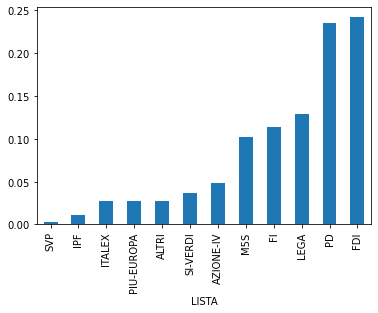

In [4]:
## percentuali scenario di base
(camera.groupby("LISTA")["VOTI_LISTA"].sum()/camera["VOTI_LISTA"].sum()).sort_values().plot(kind="bar");

## Camera dei deputati e Senato

carica la lista dei candidati in tutti i collegi

In [9]:
cand_plur=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="plurinominale_camera")
cand_uni=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="uninominale_camera")

cand_plur_senato=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="plurinominale_senato")
cand_uni_senato=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="uninominale_senato")

In [17]:
## check correct names
#set(cand_uni_senato["COLLEGIOUNINOMINALE"])

correzione per candidati comuni (da cancellare con liste definitive)

In [18]:
cand_uni.loc[cand_uni["CANDIDATO"].str.contains("Coalizione"),"CANDIDATO"]=cand_uni.loc[cand_uni["CANDIDATO"].str.contains("Coalizione"),"COLLEGIOUNINOMINALE"]+"-COALIZIONE"
cand_uni_senato.loc[cand_uni_senato["CANDIDATO"].str.contains("Coalizione"),"CANDIDATO"]=cand_uni_senato.loc[cand_uni_senato["CANDIDATO"].str.contains("Coalizione"),"COLLEGIOUNINOMINALE"]+"-COALIZIONE"

funzione per vedere chi sono gli eletti alla camera

In [19]:
### funzione per vedere chi sono gli eletti 
def eletti_plurinom_camera(alloc_seggi,partito="PD"):    
    ### prendi l'allocazione dei seggi per tutti i partiti
    eletti=pd.DataFrame()
    ### for row in allocazione_seggi...
    for i,row in alloc_seggi.iterrows():
        ### filtra gli eletti
        # in quel collegio
        # di quel partito
        # entro le posizioni assegnate
        elect_to_append=cand_plur.loc[(cand_plur["COLLEGIOPLURINOMINALE"]==row["COLLEGIOPLURINOMINALE"])&
                                      (cand_plur["PARTITO"]==partito)&
                                      (cand_plur["POSIZIONE"]<=row[partito])].copy()

        eletti=eletti.append(elect_to_append)
    return eletti

funzione per vedere chi sono gli eletti al senato

In [20]:
### funzione per vedere chi sono gli eletti 
def eletti_plurinom_senato(alloc_seggi,partito="PD"):    
    ### prendi l'allocazione dei seggi per tutti i partiti
    eletti=pd.DataFrame()
    ### for row in allocazione_seggi...
    for i,row in alloc_seggi.iterrows():
        ### filtra gli eletti
        # in quel collegio
        # di quel partito
        # entro le posizioni assegnate
        elect_to_append=cand_plur_senato.loc[(cand_plur_senato["COLLEGIOPLURINOMINALE"]==row["COLLEGIOPLURINOMINALE"])&
                                      (cand_plur_senato["PARTITO"]==partito)&
                                      (cand_plur_senato["POSIZIONE"]<=row[partito])].copy()

        eletti=eletti.append(elect_to_append)
    return eletti

funzione per calcolare i risultati degli scenari alla camera

In [21]:
def calcola_risultati_scenario_camera(camera,partito="PD"):
    #DECRETO DEL PRESIDENTE DELLA REPUBBLICA 30 marzo 1957, n. 361 art.85
    ## calcola percentuale nei collegi plurinominali
    all_results_camera=pd.merge(camera,camera_match,on="COLLEGIOUNINOMINALE")
    ## compute percentage of voti lista over votanti by lista in collegioplurinominale
    seggi_plurinom=all_results_camera.groupby(["COLLEGIOPLURINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum().pivot(index="COLLEGIOPLURINOMINALE",columns="LISTA",values="VOTI_LISTA")
    ### percentuali nei collegi
    perc_collegi=seggi_plurinom.div(seggi_plurinom.sum(axis=1),axis=0)

    ### calcola numero di seggi allocati per collegio
    allocazione_seggi=allocazione_plurinom_camera(camera=camera,diz=diz_coalizione,seggi_camera=seggi_camera)
    ### questo serve per levare collegio plurinominale dall'indice
    allocazione_seggi.reset_index(inplace=True)
    ### quanti sono in tutto
    if partito in allocazione_seggi.columns:
        num_da_eleggere=allocazione_seggi[partito].sum().copy()
        #### chi sono
        eletti=eletti_plurinom_camera(alloc_seggi=allocazione_seggi,partito=partito)
        ## trova candidati eletti in piu collegi 
        candidati_multipli=eletti["CANDIDATO"].value_counts()[eletti["CANDIDATO"].value_counts()>1].index
        ## dataframe con candidati multipli
        da_verificare=eletti.loc[eletti["CANDIDATO"].isin(candidati_multipli)]
        ## unisci ai risultati percentuali di collegio
        da_verificare=pd.merge(da_verificare,perc_collegi[partito].reset_index())

        '''
        ((1. Il deputato eletto in piu' collegi plurinominali e' proclamato
        nel collegio nel quale la lista cui appartiene ha ottenuto la  minore
        cifra elettorale percentuale di collegio  plurinominale,  determinata
        ai sensi dell'articolo 77, comma 1, lettera e) )). 
        '''
        ## verifica dove è la percentuale minima per ogni candidato (dove verrà eletto)
        da_verificare["minimo"]=da_verificare.groupby(["CANDIDATO"])[partito].transform("min")
        ## prendi i collegi dove si è liberata una posizione
        da_verificare["replace"]=da_verificare[partito]!=da_verificare["minimo"]

        '''
         ((1-bis. Il deputato eletto in un collegio uninominale e in  uno  o
        piu'  collegi  plurinominali   si   intende   eletto   nel   collegio
        uninominale)). 
        '''
        ### qui ci va una funzione per trovare i nomi degli eletti nell'uninominale

        result_uninom=tabella_uninom(camera,diz=diz_coalizione).reset_index(drop=False)
        collegi_vinti=result_uninom.loc[result_uninom["VINCITORE"].str.contains(partito),"COLLEGIOUNINOMINALE"]
        eletti_uninominale=cand_uni.loc[(cand_uni["PARTITO"]==partito)&(cand_uni["COLLEGIOUNINOMINALE"].isin(collegi_vinti)),"CANDIDATO"].unique()
        ### li aggiungo a quelli che vanno rimpiazzati
        da_verificare.loc[da_verificare["CANDIDATO"].isin(eletti_uninominale),"replace"]=True

        ## prendi dataset con collegi e posizioni da incrementare ovvero dove replace =TRUE
        incrementi=da_verificare.loc[da_verificare["replace"],"COLLEGIOPLURINOMINALE"].value_counts()
        ## incrementa le posizioni
        for collegio,incremento in incrementi.iteritems():
             allocazione_seggi.loc[allocazione_seggi["COLLEGIOPLURINOMINALE"]==collegio,partito]+=incremento

        ## adesso rifai gli eletti
        eletti=eletti_plurinom_camera(alloc_seggi=allocazione_seggi,partito=partito)
        num_cand_unici=eletti["CANDIDATO"].nunique()
        eletti_finali_plurinominali=set(eletti["CANDIDATO"].unique())
        eletti_finali=list(set(eletti_finali_plurinominali).union(set(eletti_uninominale)))
    else:
        eletti_finali=[]
    return eletti_finali

funzione per vedere i risultati dello scenario al senato

In [22]:
def calcola_risultati_scenario_senato(senato,partito="PD"):

    ## calcola percentuale nei collegi plurinominali
    all_results_camera=pd.merge(senato,senato_match,on="COLLEGIOUNINOMINALE")
    ## compute percentage of voti lista over votanti by lista in collegioplurinominale
    seggi_plurinom=all_results_camera.groupby(["COLLEGIOPLURINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum().pivot(index="COLLEGIOPLURINOMINALE",columns="LISTA",values="VOTI_LISTA")
    ### percentuali nei collegi
    perc_collegi=seggi_plurinom.div(seggi_plurinom.sum(axis=1),axis=0)

    ### calcola numero di seggi allocati per collegio
    allocazione_seggi=allocazione_plurinom_senato(senato,diz=diz_coalizione,seggi_senato=seggi_senato)
    ### questo serve per levare collegio plurinominale dall'indice
    allocazione_seggi.reset_index(inplace=True)
    ### quanti sono in tutto
    if partito in allocazione_seggi.columns:
        num_da_eleggere=allocazione_seggi[partito].sum().copy()
        #### chi sono
        eletti=eletti_plurinom_senato(alloc_seggi=allocazione_seggi,partito=partito)


        ## trova candidati eletti in piu collegi 
        candidati_multipli=eletti["CANDIDATO"].value_counts()[eletti["CANDIDATO"].value_counts()>1].index
        ## dataframe con candidati multipli
        da_verificare=eletti.loc[eletti["CANDIDATO"].isin(candidati_multipli)]
        ## unisci ai risultati percentuali di collegio
        da_verificare=pd.merge(da_verificare,perc_collegi[partito].reset_index())

        '''
        ((1. Il deputato eletto in piu' collegi plurinominali e' proclamato
        nel collegio nel quale la lista cui appartiene ha ottenuto la  minore
        cifra elettorale percentuale di collegio  plurinominale,  determinata
        ai sensi dell'articolo 77, comma 1, lettera e) )). 
        '''
        ## verifica dove è la percentuale minima per ogni candidato (dove verrà eletto)
        da_verificare["minimo"]=da_verificare.groupby(["CANDIDATO"])[partito].transform("min")
        ## prendi i collegi dove si è liberata una posizione
        da_verificare["replace"]=da_verificare[partito]!=da_verificare["minimo"]

        '''
         ((1-bis. Il deputato eletto in un collegio uninominale e in  uno  o
        piu'  collegi  plurinominali   si   intende   eletto   nel   collegio
        uninominale)). 
        '''
        ### qui ci va una funzione per trovare i nomi degli eletti nell'uninominale

        result_uninom=tabella_uninom(camera,diz=diz_coalizione).reset_index(drop=False)
        collegi_vinti=result_uninom.loc[result_uninom["VINCITORE"].str.contains(partito),"COLLEGIOUNINOMINALE"]
        eletti_uninominale=cand_uni_senato.loc[(cand_uni_senato["PARTITO"]==partito)&(cand_uni_senato["COLLEGIOUNINOMINALE"].isin(collegi_vinti)),"CANDIDATO"].unique()
        ### li aggiungo a quelli che vanno rimpiazzati
        da_verificare.loc[da_verificare["CANDIDATO"].isin(eletti_uninominale),"replace"]=True

        ## prendi dataset con collegi e posizioni da incrementare ovvero dove replace =TRUE
        incrementi=da_verificare.loc[da_verificare["replace"],"COLLEGIOPLURINOMINALE"].value_counts()
        ## incrementa le posizioni
        for collegio,incremento in incrementi.iteritems():
             allocazione_seggi.loc[allocazione_seggi["COLLEGIOPLURINOMINALE"]==collegio,partito]+=incremento

        ## adesso rifai gli eletti
        eletti=eletti_plurinom_senato(alloc_seggi=allocazione_seggi,partito=partito)
        num_cand_unici=eletti["CANDIDATO"].nunique()
        eletti_finali_plurinominali=set(eletti["CANDIDATO"].unique())
        eletti_finali=list(set(eletti_finali_plurinominali).union(set(eletti_uninominale)))
    else:
        eletti_finali=[]
    return eletti_finali

## definizione scenari

In [23]:
## aumenti rispetto allo scenario di base
aumenti=[0.25,0.5,0.75,0.85,1,1.15,1.25,1.5,1.75]
### probabilità di accadimento in ogni scenario
probabilita=[0.02,0.03,0.1,0.2,0.3,0.2,0.1,0.03,0.02]

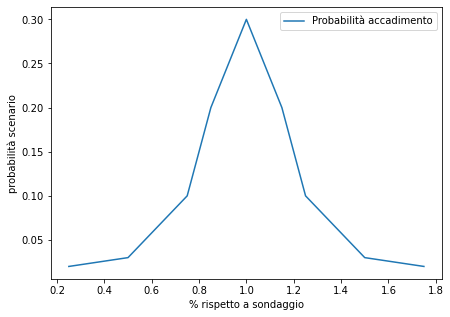

In [24]:
## distribuzione della probabilità degli scenari
fig,axs=plt.subplots(figsize=(7,5))
pd.DataFrame({"% rispetto a sondaggio":aumenti,"Probabilità accadimento":probabilita}).plot(
    kind="line",y="Probabilità accadimento",x="% rispetto a sondaggio",ax=axs)
axs.set_ylabel("probabilità scenario");

ad esempio per il PD (figura in basso linea rossa), ipotizziamo diversi scenari che vanno dal 5% al 40% su base nazionale.
Mentre per la lega (figura in basso linea blu), ipotizziamo diversi scenari che vanno 3% al 22%....Notare che gli scenari estremi (es:Lega che prende il 3% o PD che prende il 5%) hanno delle probabilità di acccadimento molto basse (2%),

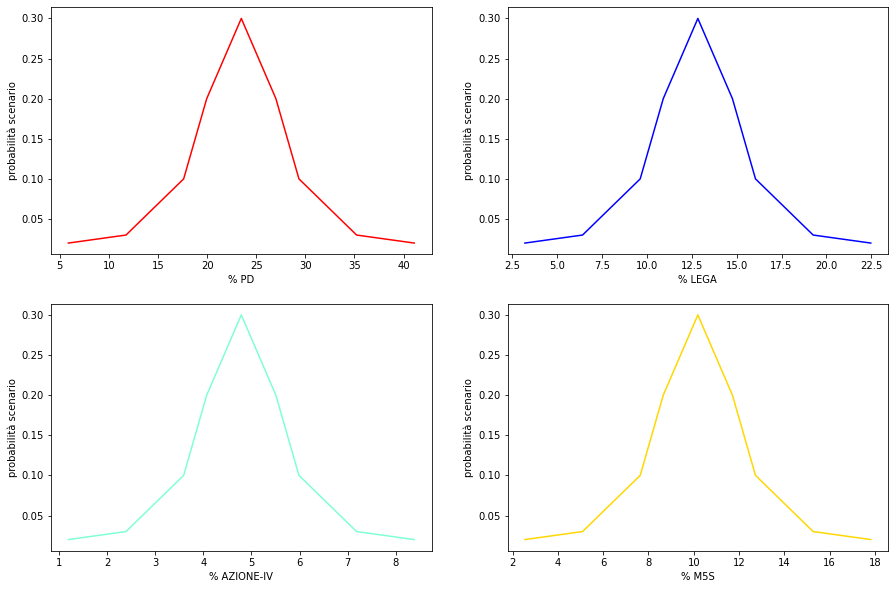

In [25]:
d_plot=pd.DataFrame({"% rispetto a sondaggio":aumenti,"Probabilità accadimento":probabilita})
for party in ["PD","LEGA","AZIONE-IV","M5S"]:    
    d_plot["% {0}".format(party)]=d_plot["% rispetto a sondaggio"]*cp(party,mean=1)*100

fig,axss=plt.subplots(ncols=2,nrows=2,figsize=(15,10))
axs=axss.flatten()

for i,party,colorz in  zip(range(0,len(axs)),["PD","LEGA","AZIONE-IV","M5S"],["red","blue","aquamarine","gold"]):    
    d_plot.plot(
        kind="line",y="Probabilità accadimento",x="% {0}".format(party),ax=axs[i],color=colorz,legend=False)
    axs[i].set_ylabel("probabilità scenario");


## Ora facciamo le simulazioni....

questa cella ci può mettere anche 10 minuti a partito...

In [27]:
%%time

eletti_camera_all=pd.DataFrame()
eletti_senato_all=pd.DataFrame()

### per il partito
for partito in ["AZIONE-IV","PD","M5S","FDI"]:
    ## per ogni aumento di ogni scenario
    for aumento in aumenti:
        ### calcola la media del partito
        media_partito=cp(partito,mean=1)

        #### aumentare la media del partito dello scenario di base per l'aumento
        aumento_voti_partito(camera,increase=media_partito*aumento,partito=partito)
        aumento_voti_partito(senato,increase=media_partito*aumento,partito=partito)
        ### calcola i risultati dello scenari
        eletti_camera=calcola_risultati_scenario_camera(camera=camera,partito=partito)
        eletti_senato=calcola_risultati_scenario_senato(senato,partito=partito)

        ### salvali in un dataframe
        eletti_camera_all=eletti_camera_all.append(pd.DataFrame({"candidato":eletti_camera,"scenario":aumento,"partito":partito}))
        eletti_senato_all=eletti_senato_all.append(pd.DataFrame({"candidato":eletti_senato,"scenario":aumento,"partito":partito}))
        ### ricalibra i dataset riportandoli allo scenario di base
        for z in range(0,20):    
            for i,party in stime.iterrows():
                aumento_voti_partito(camera,partito=party.party,increase=party.stima)
        ## for tuning
        for z in range(0,20):    
            for i,party in stime.iterrows():
                aumento_voti_partito(senato,partito=party.party,increase=party.stima)

Wall time: 1h 42min 14s


lega le probabilità di ogni scenario agli aumenti...

In [28]:
eletti_camera_all["probabilità di elezione"]=eletti_camera_all["scenario"].replace(dict(zip(aumenti,probabilita)))
eletti_senato_all["probabilità di elezione"]=eletti_senato_all["scenario"].replace(dict(zip(aumenti,probabilita)))

ora calcolà la probabilità totale sommandola su tutti gli scenari.


In [29]:
risultati_finali=eletti_camera_all.groupby(["candidato","partito"],as_index=False)["probabilità di elezione"].sum()

risultati_finali_senato=eletti_senato_all.groupby(["candidato","partito"],as_index=False)["probabilità di elezione"].sum()


## come si distribuisce la probabilità ?

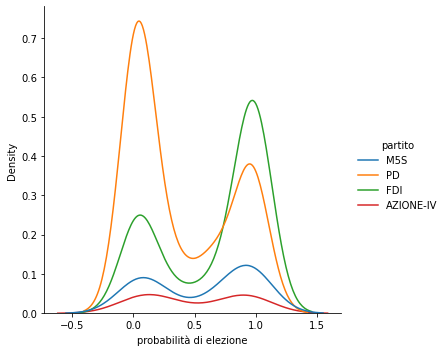

In [30]:
sns.displot(risultati_finali,x="probabilità di elezione",hue="partito",kind="kde");

In [31]:
### mostra i primi e gli ultimi
risultati_finali.sort_values("probabilità di elezione",ascending=False).head(10)

,candidato,partito,probabilità di elezione
209,Irene Manzi,PD,1.0
241,Luciano D'Alfonso,PD,1.0
36,Anna Ascani,PD,1.0
38,Anthony Barbagallo,PD,1.0
191,Giovanni Luca Cannata,FDI,1.0
310,Monica Ciaburro,FDI,1.0
125,Elly Schlein,PD,1.0
124,Elisabetta Gardini,FDI,1.0
249,Manlio Messina,FDI,1.0
362,Sara Kelany,FDI,1.0


In [32]:
risultati_finali_senato.sort_values("probabilità di elezione",ascending=False).head(10)

,candidato,partito,probabilità di elezione
63,Ernesto Rapani,FDI,1.0
53,Dario Parrini,PD,1.0
61,Enrico Borghi,PD,1.0
69,Filippo Melchiorre,FDI,1.0
111,Marcello Pera,FDI,1.0
33,COALIZIONE,FDI,1.0
66,Fausto Orsomarso,FDI,1.0
151,Sandra Zampa,PD,1.0
105,Luca Ciriani,FDI,1.0
154,Sebastiano Musumeci,FDI,1.0


in media qual'è la probabilità di essere eletti per una data posizione in lista?

In [33]:
check=pd.merge(risultati_finali,
        cand_plur.groupby("CANDIDATO",as_index=False)["POSIZIONE"].min(),right_on="CANDIDATO",left_on="candidato")

<AxesSubplot:xlabel='POSIZIONE'>

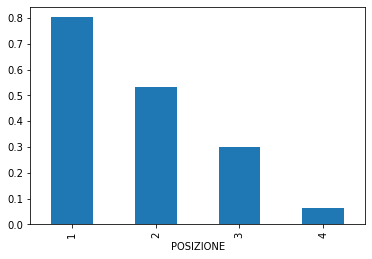

In [34]:
check.groupby("POSIZIONE")["probabilità di elezione"].mean().plot(kind="bar")

## animazione

In [35]:
diz_colori={"PD":"red","AZIONE-IV":"blue","M5S":"gold","FDI":"darkblue"}

In [36]:
risultati_finali["camera"]="Camera"
risultati_finali_senato["camera"]="Senato"

In [37]:
risultati_all=risultati_finali.append(risultati_finali_senato)

MovieWriter imagemagick unavailable; using Pillow instead.


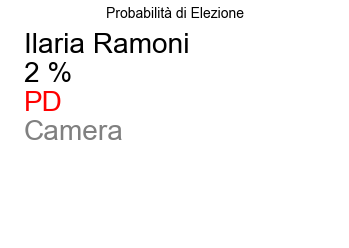

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(-1,0), ylim=(-0.5,1))
ax.set_axis_off()
ax.set_title("Probabilità di Elezione",font="Arial",fontsize=14)
margine_sinistro=-0.95
#ax.text(x=margine_sinistro,y=0.5,s="probabilità di essere eletto",fontsize=5)

probabilita = ax.text(x=margine_sinistro,y=0.6, s="30%", fontsize=28,font="Arial")
candidato = ax.text(x=margine_sinistro,y=0.8, s="ELEZIONI 25 SETTEMBRE \n #totoparlamentarie", fontsize=28,font="Arial")
partito = ax.text(x=margine_sinistro,y=0.4, s="", fontsize=28,font="Arial")
camera_testo = ax.text(x=margine_sinistro,y=0.2, s="", fontsize=28,font="Arial")

### filtra quelliu della coalizione
risultati_all=risultati_all.loc[~risultati_all["candidato"].str.contains("COALIZIONE")].copy()
risultati_all.sort_values("probabilità di elezione",inplace=True,ascending=False)
risultati_all.reset_index(drop=True,inplace=True)



candidati = risultati_all["candidato"]
probabilities= risultati_all["probabilità di elezione"].apply(lambda x:str(int(x*100))+" %")
partiti=risultati_all["partito"]
colori=risultati_all["partito"].replace(diz_colori)
camere=risultati_all["camera"]
camere_colori=risultati_all["camera"].replace({"Camera":"grey","Senato":"black"})
def animate(i):
    cand=candidati[i]
    prob=probabilities[i]
    part=partiti[i]
    col=colori[i]
    cam=camere[i]
    col_camere=camere_colori[i]
    candidato.set_text(cand)
    probabilita.set_text(prob)
    partito.set_text(part)
    partito.set_color(col)
    camera_testo.set_text(cam)
    camera_testo.set_color(col_camere)
    
    return candidato,probabilita,partito,camera_testo

anim = FuncAnimation(fig, animate,frames=len(candidati), interval=250, blit=True)


anim.save('animazione_parlamentari.gif', writer='imagemagick')

In [39]:
risultati_all["probabilità di elezione %"]=risultati_all["probabilità di elezione"]*100
risultati_all.to_csv("risultati_simulazione.csv")

## Analisi effetto uninominale

In [40]:
### calcola risultati per la camera
result=compute_uninom(camera=camera,diz=diz_coalizione)
result["Seggio"]="uninominale"
result2=compute_plurinom_camera(camera=camera,diz=diz_coalizione)
result2["Seggio"]="plurinominale"
result=result.append(result2)
result=result.append(pd.DataFrame({"seggi":[8],"Seggio":"plurinominale","partiti":"ESTERO"}))
result.sort_values(["seggi","Seggio"],ascending=False,inplace=True)

### calcola risultati per il  senato
result_senato=compute_uninom(camera=senato,diz=diz_coalizione)
result_senato["Seggio"]="uninominale"
result2_senato=compute_plurinom_senato(camera=senato,diz=diz_coalizione)
result2_senato["Seggio"]="plurinominale"
result_senato=result_senato.append(result2_senato)
result_senato=result_senato.append(pd.DataFrame({"seggi":[4],"Seggio":"plurinominale","partiti":"ESTERO"}))
result_senato.sort_values(["seggi","Seggio"],ascending=False,inplace=True)

## modifica
result["parlamento"]="camera"
result_senato["parlamento"]="senato"
all_camere=result.append(result_senato)
all_camere=all_camere.groupby(["parlamento","partiti"],as_index=False)["seggi"].sum()


In [41]:
camu=all_camere.loc[all_camere["parlamento"]=="camera",].copy()
senu=all_camere.loc[all_camere["parlamento"]=="senato",].copy()

camu["perc"]=camu.seggi/camu.seggi.sum()
senu["perc"]=senu.seggi/senu.seggi.sum()

camu["sistema"]="plurinominale (2/3) uninominale (1/3)"
senu["sistema"]="plurinominale (2/3) uninominale (1/3)"

In [42]:
cam=compute_plurinom_camera(camera,diz=diz_coalizione)
sen=compute_plurinom_senato(senato,diz=diz_coalizione)

cam["perc"]=cam.seggi/cam.seggi.sum()
sen["perc"]=sen.seggi/sen.seggi.sum()

cam["sistema"]="plurinominale 1/1"
sen["sistema"]="plurinominale 1/1"

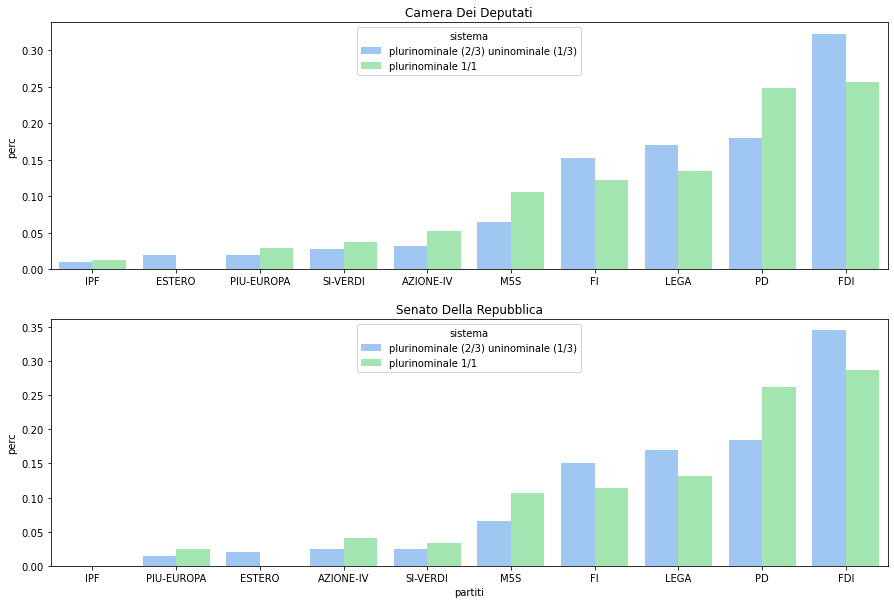

In [43]:
fig,axs=plt.subplots(figsize=(15,10),nrows=2)
sns.barplot(data=camu.append(cam).sort_values(["perc","sistema"]),y="perc",x="partiti",hue="sistema",ax=axs[0])
axs[0].set_title("Camera Dei Deputati")
axs[0].set_xlabel("")

sns.barplot(data=senu.append(sen).sort_values(["perc","sistema"]),y="perc",x="partiti",hue="sistema",ax=axs[1])

axs[1].set_title("Senato Della Repubblica");
#axs[0].set_xlabel("")


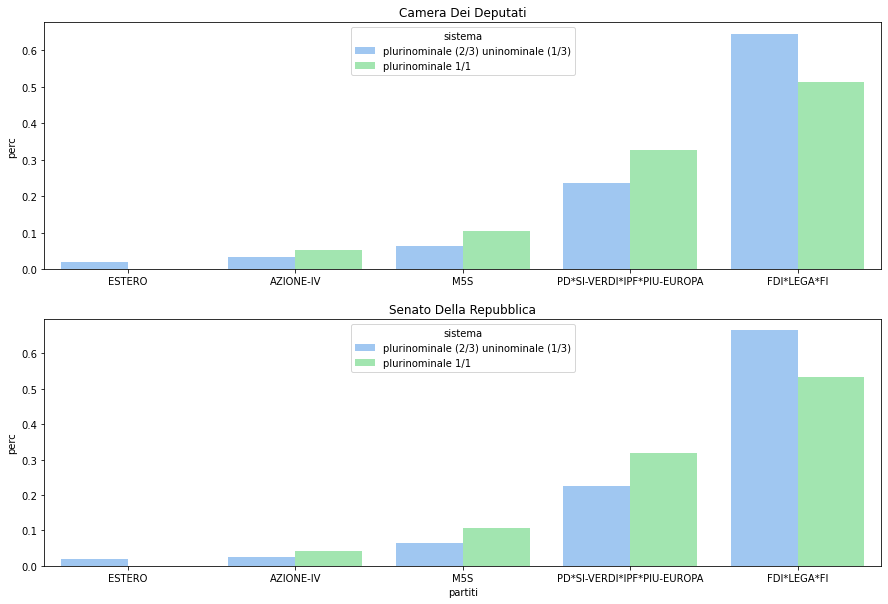

In [44]:
fig,axs=plt.subplots(figsize=(15,10),nrows=2)
sns.barplot(data=camu.append(cam).replace(diz_coalizione).groupby(["partiti","sistema"],as_index=False)["perc"].sum().sort_values(["perc","sistema"]),y="perc",x="partiti",hue="sistema",ax=axs[0])
axs[0].set_title("Camera Dei Deputati")
axs[0].set_xlabel("")

sns.barplot(data=sen.append(senu).replace(diz_coalizione).groupby(["partiti","sistema"],as_index=False)["perc"].sum().sort_values(["perc","sistema"]),y="perc",x="partiti",hue="sistema",ax=axs[1])

axs[1].set_title("Senato Della Repubblica");


##  import candidati 5 stelle

In [212]:
# candidati=pd.read_excel("D:\\Download_new\\LISTE-DI-CANDIDATI-CAMERA(1)(1).xlsx",sheet_name="Table 1")
# candidati2=pd.read_excel("D:\\Download_new\\LISTE-DI-CANDIDATI-CAMERA(1)(1).xlsx",sheet_name="Table 2")

camera

In [213]:
# df=pd.DataFrame()
# for g,collegio in zip(candidati.iloc[1:,2],candidati.iloc[1:,1]):
#     candidati_collegio=re.sub(r'\d',"", g.replace("\n","")).split(")  ")[1:]
#     candidati_collegio=[x for x in candidati_collegio if "  " not in x]
#     df=df.append(pd.DataFrame({"COLLEGIOPLURINOMINALE":collegio,"CANDIDATO":candidati_collegio,"POSIZIONE":range(1,len(candidati_collegio)+1)}))

# for g,collegio in zip(candidati2.iloc[1:,2],candidati2.iloc[1:,1]):
#     candidati_collegio=re.sub(r'\d',"", g.replace("\n","")).split(")  ")[1:]
#     candidati_collegio=[x for x in candidati_collegio if "  " not in x]
#     df=df.append(pd.DataFrame({"COLLEGIOPLURINOMINALE":collegio,"CANDIDATO":candidati_collegio,"POSIZIONE":range(1,len(candidati_collegio)+1)}))

# df["COLLEGIOPLURINOMINALE"]=df["COLLEGIOPLURINOMINALE"].apply(lambda x:x.split(" -")[0]+" - P"+x.split("- ")[1])

In [215]:
# df.to_excel("D:\\Download_new\\candidati_camera.xlsx")

senato

In [216]:
# candidati=pd.read_excel("D:\\Download_new\\LISTE-DI-CANDIDATI-SENATO(1).xlsx",sheet_name="Table 1")
# dr=pd.DataFrame()
# for g,collegio in zip(candidati.iloc[1:,2],candidati.iloc[1:,1]):
#     candidati_collegio=re.sub(r'\d',"", g.replace("\n","")).split(")  ")[1:]
#     candidati_collegio=[x.replace("   ","") for x in candidati_collegio]
#     dr=dr.append(pd.DataFrame({"COLLEGIOPLURINOMINALE":collegio,"CANDIDATO":candidati_collegio,"POSIZIONE":range(1,len(candidati_collegio)+1)}))
# dr["COLLEGIOPLURINOMINALE"]=dr["COLLEGIOPLURINOMINALE"].apply(lambda x:x.split(" -")[0]+" - P"+x.split("- ")[1])

In [217]:
# dr.to_excel("D:\\Download_new\\candidati_senato.xlsx")